This notebook genrates spectrograms from raw, windowized EEG data. It is intended to be executed in Google Colab, with Google Drive used as the default destination for the generated images.

The dataset used here is a small collection of EEG data from healthy adolescents and adolescents with schizophrenia. The description is available here: http://brain.bio.msu.ru/eeg_schizophrenia.htm or https://web.archive.org/web/20191216034839/http://brain.bio.msu.ru/eeg_schizophrenia.htm

To ensure availability of the data, the files are read from a remote copy.

Raw data is windowized but quality is maintained (i.e., features and number of channels are not modified). Samples are homogeneous in size and no cropping is required. Data resolution is 128 Hz.
The windowization process takes distinct 5-second slices of the data, which are offset by 30% (in other words, each sample overlaps the previous sample by 70%).

The spectrogram generator bases NFFT, noverlap and Fs values on the length of the data.
<br>Specifically, 
<br> Fs = len(data)
<br>NFFT = len(data)/4
<br> noverlap = NFFT -1

The generator uses a figsize(5,5) which, with margins, results in images of size ‪279 x 271‬.
The output folder is zipped for later use. The file size is about 112 MB.


In [22]:
from matplotlib.pyplot import specgram
import numpy as np
import pandas as pd
###################################
# If generate_images is set to False and '%%capture' is removed below, 
# the notebook will only read in and process the raw data
generate_images=True 


### Example of specgram() on random data




(array([[0.03791149, 0.03812941, 0.0383469 , ..., 0.03799401, 0.0383803 ,
         0.03877521],
        [0.0172368 , 0.01787826, 0.01861652, ..., 0.01969649, 0.02058119,
         0.02145752],
        [0.00019102, 0.00015134, 0.00011934, ..., 0.00059017, 0.00067487,
         0.00076112],
        ...,
        [0.00013285, 0.00017526, 0.00022114, ..., 0.0001954 , 0.00018155,
         0.00017046],
        [0.00143395, 0.00145724, 0.00147406, ..., 0.00054741, 0.0004702 ,
         0.00039644],
        [0.00132623, 0.00133686, 0.00133497, ..., 0.00081594, 0.00081419,
         0.00081062]]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.]),
 array([0.125     , 0.12890625, 0.1328125 , 0.13671875, 0.140625  ,
        0.14453125, 0.1484375 , 0.15234375, 0.15625   , 0.16015625,
        0.1640625 , 0.16796875, 0.171875  , 0.175

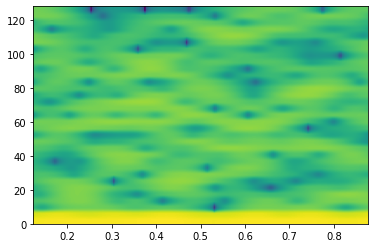

In [23]:
data = np.random.rand(256)
specgram(data, NFFT=64, noverlap=63, Fs=256)

In [3]:
import pandas as pd
import numpy as np

In [4]:

import os
import sys
raw_data_dir = ''
plot_examples = False # Notebook file size will increase by between 30 and 60MB if set to True; <1MB otherwise
github_validation_token = "c8382f66a90890ccff2d2111f987f343b2abf4c6" #https://github.com/settings/tokens/new

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')

    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio==1.0.0
    
    if not os.path.exists('/content/tmp/eeg_sz/ReadData'):
        os.makedirs('/content/tmp/eeg_sz/ReadData')
        os.makedirs('/content/tmp/eeg_sz/utils')
    # Download project utilities and data reader 
    !curl -u MTynes:{github_validation_token} https://raw.githubusercontent.com/WinAIML/schizophrenia/master/ReadData/RawDataReader.py > /content/tmp/eeg_sz/ReadData/RawDataReader.py
    !curl -u MTynes:{github_validation_token} https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ModelBuilder.py > /content/tmp/eeg_sz/utils/ModelBuilder.py
    !curl -u MTynes:{github_validation_token} https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ChartBuilder.py > /content/tmp/eeg_sz/utils/ChartBuilder.py
    sys.path.append('/content/tmp/eeg_sz/')


else:
  print('This notebook was designed to be executed on Google Colab')



import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


import ReadData.RawDataReader as data_reader
import utils.ModelBuilder as model_builder
import utils.ChartBuilder as chart_builder


Using Google Colab. Setting up environment
     |████████████████████████████████| 6.4MB 9.9MB/s 
     |████████████████████████████████| 1.1MB 10.9MB/s 
  Created wheel for pyedflib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=912699 sha256=531747232406ae3e36aa4c8108591cd4a3c584d8593e99b94d571b4305ef418c
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyedflib
     |████████████████████████████████| 81kB 4.7MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20936  100 20936    0     0  73718      0 --:--:-- --:--:-- --:--:-- 73978
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11372  100 11372    0     0  39079      0 --:--:-- --:--:-- --:--:-- 39079
  % Total    % R

Read in data previously downloaded from http://brain.bio.msu.ru/eeg_schizophrenia.htm  and process the files so that the final output is a series of spectrograms for each patient. Using 5 second time window and 70% overlap

In [5]:
import gdown
gdown.download('https://drive.google.com/uc?id=14mC2Yyu9YPouG2ol4UvoLCxGHYIZlbu1', 'msu_data.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14mC2Yyu9YPouG2ol4UvoLCxGHYIZlbu1
To: /content/msu_data.zip
17.5MB [00:00, 107MB/s] 


'msu_data.zip'

In [6]:
# unzip the content
import os
raw_data_dir = '/content/msu_data'
if not os.path.exists(raw_data_dir):
  os.makedirs(raw_data_dir)
!unzip -qq /content/msu_data.zip -d {raw_data_dir}

In [7]:
from IPython.display import display
import numpy as numpy
import pandas as pd
# iterate over the files for each group and combine them
group_dirs = ['norm', 'sch']
group_names = ['hc', 'sz']
def extract_patient_data(group_dir):
  meta = pd.DataFrame()
  raw_data_dir = '/content/msu_data/Dataset 2 - brain.bio.msu.ru/{}'.format(group_dir)
  for patient_file in os.listdir(raw_data_dir):
    df = pd.read_csv(raw_data_dir + '/' + patient_file, header=None)
    meta[patient_file.split('.')[0]] = df[0]
  return meta

hc_data, sz_data = extract_patient_data('norm'), extract_patient_data('sch')



In [24]:



print('Shape of data for healthy controls: ', hc_data.shape)
print('Shape of data for schizophrenic patients: ', sz_data.shape)
print('\nSample of data for healthy controls:')
hc_data.head(3)


Shape of data for healthy controls:  (122880, 39)
Shape of data for schizophrenic patients:  (122880, 45)

Sample of data for healthy controls:


,S153W1,s173w1,S164W1,s43w1,S10W1,S85W1,S42W1,s27w1,S154W1,s53w1,s20w1,S155W1,S177W1,S179W1,s152w1,S182W1,S60W,S72W1,S47W1,S26W1,s176w1,S167W1,s12w1,S55W1,S169W,S163W1,s94w1,S196W1,s170w1,S50W,S31W,S78W,S18W1,S174W1,s178w1,s158w1,S165W1,S59LW,s157w1
0,228.97,289.97,9.48,409.33,347.78,328.63,-154.12,109.39,148.97,169.22,136.43,49.58,89.58,49.52,89.53,508.60,-273.99,48.24,209.28,468.59,-151.40,-91.45,-30.06,-13.28,269.66,309.04,-310.93,-130.34,128.81,248.66,308.45,188.79,26.43,549.10,-350.69,68.85,8.95,148.14,-131.80
1,69.32,249.13,109.94,389.94,507.87,409.19,-112.09,129.14,109.99,88.84,119.38,29.07,28.73,29.18,129.06,606.81,-311.78,-11.58,327.87,289.67,-230.01,-91.45,-70.74,-73.03,229.80,349.67,-330.86,-211.09,128.81,229.26,248.96,129.17,147.27,588.91,-250.14,68.85,-10.07,109.15,-30.56
2,-170.15,229.73,308.96,629.08,488.54,489.76,-154.12,-150.41,48.73,-90.96,85.27,49.58,-10.14,49.52,269.74,547.18,-330.68,88.76,669.70,-10.65,-330.46,-150.39,-90.19,-351.87,148.90,388.84,-170.08,-130.34,68.78,229.26,328.28,89.43,207.69,469.48,-131.20,109.21,-170.04,-31.19,-131.80


In [9]:

# There are 39 and 45 subjects in the HC and SZ groups, respectively, and 16 channels in both groups.
# Split the data so that it is in the shape (subject, time_window, channel).
chans = 16
hc_data_array = np.asarray(hc_data.astype('float64', errors='raise'))\
        .reshape(hc_data.shape[1], int(hc_data.shape[0]/ chans), chans)
sz_data_array = np.asarray(sz_data.astype('float64', errors='raise'))\
        .reshape(sz_data.shape[1], int(sz_data.shape[0]/chans), chans)

resolution_hz = 128
time_window = 5 * resolution_hz

# Apply windowization
hc_data_split = data_reader.windowize_list(hc_data_array, time_window, overlap_rate=0.7)
sz_data_split = data_reader.windowize_list(sz_data_array, time_window, overlap_rate=0.7)

print('Shape of split data for healthy controls: ', np.array(hc_data_split).shape)
print('Shape of split data for schizophrenic patients: ', np.array(sz_data_split).shape)


Shape of split data for healthy controls:  (1443, 640, 16)
Shape of split data for schizophrenic patients:  (1665, 640, 16)


In [10]:
# Revert one-hot encodings to simple labels
# The first label should be the class that was originally set to 0 before one-hot encoding was applied;
# Healthy Controls will be the 0 class in this case
def convert_one_hot_labels_to_strings(data_array, label_1, label_2):
    label_strings = []
    for label in data_array:
        if np.array_equal(label, [1., 0.]):
            string_label = label_1
        else:
            string_label = label_2
        label_strings.append(string_label)
    return label_strings

In [11]:
%%capture
## ^^ do not display charts


import matplotlib.pyplot as plt 
import math

class image_data_generator(object):
    # modified from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/specgram_demo.html
    def generate_spectrogram(self, data, save_chart=True, display_chart=False, 
                             window_len=24, n_channels=14,
                             file_name='test.png', log_spec_variables=False):
        x = data
        NFFT = int(len(data)/4) # default value #24  # the length of the windowing segments /  Number of DFT points
        Fs = len(data)         #   sampling frequency set to number of channels
        plt.ioff()
        plt.tick_params(
            axis='x',           # changes apply to the x-axis
            which='both',       # both major and minor ticks are affected
            bottom=False,       # ticks along the bottom edge are off
            top=False,          # ticks along the top edge are off
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off

        fig = plt.figure(figsize=(5, 5))
        
        ax = fig.add_subplot()
        if log_spec_variables:
          print('NFFT value: ',NFFT)
          print('Fs value: ', Fs)
          print('noverlap value: ', (NFFT-1))
        Pxx, freqs, bins, im = ax.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=NFFT-1)#int(math.ceil(window_len/3)))
        # The `specgram` method returns 4 objects. They are:
        # - Pxx: the periodogram
        # - freqs: the frequency vector
        # - bins: the centers of the time bins
        # - im: the matplotlib.image.AxesImage instance representing the data in the plot
        #fig.get_xaxis().set_visible(False)
        #fig.get_yaxis().set_visible(False)
        
        plt.axis('off')

        fig.savefig(file_name,bbox_inches='tight', transparent="True", pad_inches=0)
        if display_chart:
            plt.show()
            
        # close the plt session so that plt can be accessed without generating older charts
        plt.close('all')

    # Flatten data from all channels; group by time.
    # X: 2-d array with channels as the second axis.
    def flatten_data(self, X):
        x_adj = [] 
        for t in X:
            x_adj = np.append(x_adj, t)
        return x_adj

    def generate_image_files(self, batch, batch_labels, group_name, output_dir,
                                                  window_len=24, n_channels=14):
        distinct_batch_labels = list(set(batch_labels))
        if not os.path.exists(output_dir+ group_name+'/'+distinct_batch_labels[0]):
            for dbl in distinct_batch_labels:
                os.makedirs(output_dir+group_name+'/'+ dbl)
        for i,sample in enumerate(batch):
            data_f = self.flatten_data(sample)
            label = batch_labels[i]
            # if normal params are used, an example would be gen_data_test/sz/sz3/sz3_45.png
            f_name=output_dir + '/{}/{}/{}_{}.png'.format(group_name, label, label, i)
            #ImageDataGenerator expects files to be seperated by set/group and class
            self.generate_spectrogram(data_f, save_chart=True, 
                                 file_name=f_name, window_len=window_len, n_channels=14) 
            plt.close('all')




In [12]:
hc_data.astype('float64', errors='ignore')


,S153W1,s173w1,S164W1,s43w1,S10W1,S85W1,S42W1,s27w1,S154W1,s53w1,s20w1,S155W1,S177W1,S179W1,s152w1,S182W1,S60W,S72W1,S47W1,S26W1,s176w1,S167W1,s12w1,S55W1,S169W,S163W1,s94w1,S196W1,s170w1,S50W,S31W,S78W,S18W1,S174W1,s178w1,s158w1,S165W1,S59LW,s157w1
0,228.97,289.97,9.48,409.33,347.78,328.63,-154.12,109.39,148.97,169.22,136.43,49.58,89.58,49.52,89.53,508.60,-273.99,48.24,209.28,468.59,-151.40,-91.45,-30.06,-13.28,269.66,309.04,-310.93,-130.34,128.81,248.66,308.45,188.79,26.43,549.10,-350.69,68.85,8.95,148.14,-131.80
1,69.32,249.13,109.94,389.94,507.87,409.19,-112.09,129.14,109.99,88.84,119.38,29.07,28.73,29.18,129.06,606.81,-311.78,-11.58,327.87,289.67,-230.01,-91.45,-70.74,-73.03,229.80,349.67,-330.86,-211.09,128.81,229.26,248.96,129.17,147.27,588.91,-250.14,68.85,-10.07,109.15,-30.56
2,-170.15,229.73,308.96,629.08,488.54,489.76,-154.12,-150.41,48.73,-90.96,85.27,49.58,-10.14,49.52,269.74,547.18,-330.68,88.76,669.70,-10.65,-330.46,-150.39,-90.19,-351.87,148.90,388.84,-170.08,-130.34,68.78,229.26,328.28,89.43,207.69,469.48,-131.20,109.21,-170.04,-31.19,-131.80
3,-191.16,289.97,348.76,728.18,369.86,468.56,-154.12,-250.68,29.24,-112.11,102.33,88.91,69.30,69.85,309.27,487.55,-292.89,148.58,748.76,-110.76,-350.85,-231.68,29.18,-431.53,128.97,388.84,-90.36,-150.17,48.77,308.62,429.63,129.17,86.85,329.46,-50.27,89.03,-250.59,-70.17,-210.11
4,-210.06,329.79,269.15,769.11,347.78,508.84,-14.01,-150.41,69.61,88.84,136.43,49.58,309.32,129.98,309.27,129.78,-273.99,109.99,609.24,-110.76,-430.91,-191.03,229.90,-331.95,109.04,468.64,-70.43,9.92,8.75,449.71,469.29,409.05,-30.21,28.83,169.21,-51.05,-350.16,7.80,-431.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122875,-81.92,-250.15,-170.59,-1281.85,-110.41,527.92,-32.69,399.57,-270.10,-90.96,-648.06,408.65,28.73,-100.80,-190.68,-371.80,-434.61,358.92,-111.62,268.37,478.95,-731.61,-270.57,-132.78,429.12,-181.36,-1340.73,-640.35,-570.28,-1331.49,-550.81,-410.71,139.72,728.93,79.70,339.51,-30.21,278.09,448.88
122876,199.56,-10.21,-411.31,-51.70,-430.58,498.24,158.79,218.78,-391.23,-171.34,-767.44,8.55,-380.31,39.79,-730.16,7.02,-321.23,418.73,-81.39,438.77,1219.95,-731.61,79.58,497.92,309.53,-60.94,-1090.92,-230.92,-510.25,-1070.48,-451.66,418.99,147.27,838.74,9.81,39.17,219.27,38.98,479.44
122877,388.62,189.91,-530.73,308.08,-571.35,498.24,177.47,118.51,-410.72,-260.18,-613.95,-90.62,-510.46,189.22,-570.87,336.73,-222.03,258.57,-11.63,609.16,1439.78,-611.70,279.41,557.67,379.87,-50.78,-810.55,148.75,-360.18,-751.28,-370.14,1069.83,139.72,768.73,-141.01,-51.05,279.68,-101.36,429.78
122878,258.38,479.87,-610.34,829.43,-632.07,349.83,317.58,0.00,-370.35,-410.37,17.05,-321.45,-571.31,389.94,-30.23,817.26,47.24,198.75,209.28,739.09,1528.58,-270.29,439.46,517.84,529.95,0.00,-390.66,179.92,-90.04,98.76,-121.18,1268.56,237.90,439.28,-440.20,-330.01,199.13,-501.59,340.00


In [13]:
#files will be written out to a Google Drive directory
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [15]:

reload(plt)  


# Declare the location that will used as the destination for the generator,
# and as the source for the model (ImageDataGenerator).
content_directory = '/content/drive/My Drive/ML Projects/data'
output_directory = content_directory + '/Dataset2__gen_data_5s_70pct_overlap_-_fractional_noverlap_all_channels_sml_all_participants_v2/' # must end with file seperator
if not os.path.isdir(output_directory):
  os.mkdir(output_directory)


# subject_group_data: list or np array; cleaned EEG data for one subject group
# group_label: str - the name used for the group in the file system - e.g., 'hc' for healthy controls
# time_window: int - the length of the time slices for the raw data reader
# overlap rate - float between 0 and 1; the sample window overlap rate for the raw data reader
# output_directory: str - the destination folder
# window_len: int - the length of the windowing segments for the specgram/spectrogram; default is 24
# n_channels - number of channels in the data; used here to determine the sampling frequency of the spectrogram
def generate_images_by_subject(subject_group_data, group_label, time_window, overlap_rate, output_directory,
                              window_len=50, n_channels=chans):
    print('Generating images....')
    image_generator = image_data_generator()
    for i, subject_data in enumerate(subject_group_data):
        subject_label = group_label + str(i) # to be used for file naming
        # subject_data = subject_data.astype('float64')
        print('shape of data before cleanup: ', np.asarray(subject_data).shape)
        cleaned_data = []
        for j in subject_data:
            sd = pd.to_numeric(j, errors='coerce')
            cleaned_data.append(sd)
        subject_data = np.asarray(cleaned_data)
        print('shape of data after cleanup: ', subject_data.shape)
        subject_data = data_reader.windowize_list([subject_data], time_window, overlap_rate=overlap_rate)
        print('subject index: ', i)
        print('subject_data shape: ', np.asarray(subject_data).shape)
        # Send to updated generator
        batch_labels = [subject_label for i in subject_data] # to avoid modifying the original image generator, duplicate the label. the subject is the group in this case
        # print('batch labels: ', str(batch_labels))
        image_generator.generate_image_files(subject_data, batch_labels, group_label, output_directory,
                                            window_len, n_channels)


if generate_images:
    window_len= time_window*2 #set NFFT  #int(time_window/2) #math.ceil(time_window/5) 
    generate_images_by_subject(hc_data_array, 'hc', time_window, 0.7, output_directory, 
                               window_len=window_len, n_channels=chans)
    plt.close('all')
    generate_images_by_subject(sz_data_array, 'sz', time_window, 0.7, output_directory, 
                               window_len=window_len, n_channels=chans)

plt.close('all')


Generating images....
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  0
subject_data shape:  (37, 640, 16)
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  1
subject_data shape:  (37, 640, 16)
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  2
subject_data shape:  (37, 640, 16)
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  3
subject_data shape:  (37, 640, 16)
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  4
subject_data shape:  (37, 640, 16)
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  5
subject_data shape:  (37, 640, 16)
shape of data before cleanup:  (7680, 16)
shape of data after cleanup:  (7680, 16)
subject index:  6
subject_data shape:  (37, 640, 16)
shape of data before clean

In [16]:
# Save the output directory as a zip file so that it can later be shared and used in ML pipelines
# from https://stackoverflow.com/a/1855118/2466781
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

if __name__ == '__main__':
    zipf = zipfile.ZipFile(output_directory[:-1] + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(output_directory, zipf)
    zipf.close()

In [19]:
print('Output saved to  '+ output_directory[:-1] +'.zip')

Output saved to  /content/drive/My Drive/ML Projects/data/test_Dataset-2__gen_data_5s_70pct_overlap_-_high_nfft_all_channels.zip


In [20]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.0
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
chart-studio==1.0.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.5
dlib==19.18.0
dm-tree==0.1.5
d

In [21]:
from platform import python_version

print(python_version())

3.6.9
